<a href="https://colab.research.google.com/github/JosephGesnouin/Unsup_gener_nets/blob/main/TP_modeles_g%C3%A9n%C3%A9ratifs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Apprentissage profond non-supervisé: modèles génératifs TP.

##Joseph Gesnouin - joseph.gesnouin@mines-paristech.fr

Assurez vous que le notebook utilise le GPU disponible dans google collab: "Execution -> modifier le type d'execution -> GPU"

Sources: https://people.minesparis.psl.eu/fabien.moutarde/ES_LSML/Slides/deepLearning-DBN-DSA-GAN_course-FabienMOUTARDE_2pp.pdf

###Introduction

Dans ce TP, vous apprendrez à utiliser les Auto-encodeurs (dense, CNN, VAE) et les GANS pour la génération de nouvelles instances d'entrainement via le deep unsupervised learning.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.random.set_seed(42)

from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, BatchNormalization, Flatten, Conv2DTranspose, Reshape,concatenate
import keras
from sklearn.model_selection import train_test_split
import os 
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
np.random.seed(37)
import random as rn
rn.seed(1254)
import tensorflow as tf
tf.random.set_seed(0)

from tensorflow.compat.v1.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

print("[INFO] loading Fashion MNIST...")
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_x = train_images.reshape(-1, 28, 28, 1)
test_x = test_images.reshape(-1, 28, 28, 1)
train_y = train_labels
test_y = test_labels

###on travaille sur le test set directement car plus petit: histoire que le notebook tourne en entier pendant la durée du TP
train_x = test_x
train_y = test_y

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)


## reshape the inputs
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

## normalize and reshape the predictors  
train_x = train_x / 255
val_x = val_x / 255


Found GPU at: /device:GPU:0
[INFO] loading Fashion MNIST...
4423680/4422102 [==============================] - 0s 0us/step


On travaille ici sur le jeu de données FashionMnist: un jeu de données de qui contient 70 000 images réparties sur 10 catégories. Les images montrent des vêtements Zalando, en basse résolution (28 x 28 pixels).

Pour que le TP tourne suffisament rapidement, on va se concentrer sur un subset du jeu de données.

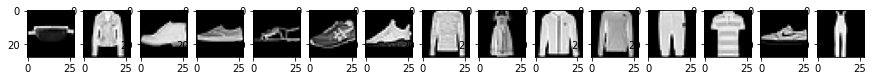

In [2]:
from PIL import Image 
import matplotlib.pyplot as plt
f, ax = plt.subplots(1,15)
f.set_size_inches(15, 40)
for i in range(15):
    ax[i].imshow(train_x[i].reshape(28, 28),cmap='gray')
plt.show()

#Partie 1: Auto-encoders classiques (dense et CNN)

Un **AutoEncodeur** prend des données d'entrée avec une très haute dimensionnalité et va fonctionner à travers un réseau neuronal. Celui-ci va essayer de compresser les données pour les obtenir dans une représentation plus petite.


![](https://i.imgur.com/9PrT1KA.png)

Il se déroule en deux étapes


*  La première est ce que l'on peut considérer comme l'étape d'encodage: L'encodeur correspond à un amas de couche (fully connected, convolutives, récurrentes...) qui vont prendre l'entrée et la comprimer jusqu'à obtenir une représentation de dimension plus réduite que l'entrée: c'est le 'goulot d'étranglement' ou bottleneck.
*   A partir du bottleneck, la seconde partie correspond à une tentative de reconstruction de la donnée initiale.

Plus le nombre de dimensions dans l'espace latent est élevé, plus les reconstructions seront claires et robustes.

La fonction de cout d'un AE, consiste simplement à reconstruire le jeu de données initial et calculer la perte de reconstruction par rapport à l'entrée. Dans sa forme la plus basique, la solution optimale d'un AE est fortement lié à la PCA:

Afin de calculer les valeurs des couches cachées, on multiplie simplement les poids entre l'entrée et la couche, on a donc la formule suivante:

z = f(Wx)

Pour obtenir la sortie, on multiplie les poids entre les couches cachées et la sortie par la valeur des couches cachées, on obtient donc:

y = g(Vz)

les fonctions f et g sont libres, tant qu'elles sont non lineaires et qu'on peut les dériver pour la backpropagation. On obtient donc la fonction suivante:

y = g(V(f(Wx)) = VWx

nous permettant d'obtenir la fonction objectif:

![](https://i.imgur.com/HLH7ZhO.png)

Ce qui correspond à la fonction objectif de la PCA. Cependant, l'autoencodeur est bien plus flexible que la PCA: chaque couche dispose d'une fonction d'activation (Relu, tanh, sigmoide...) permettant d'introduire la notion de non linéarité, contrairement à la PCA qui ne peut représenter que des transformations linéaires. Avec des contraintes de dimensionalité et de parcimonie appropriées, les AE peuvent donc apprendre des projections de données plus intéréssantes que l'ACP, de plus ils peuvent être empilés...

Passons maintenant aux méthodes d'apprentissage profond pour la réduction de dimension: les auto-encodeurs (Dense et CNN).


In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Un deep autoencoder dense multicouches:

In [4]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(512, activation='relu')(input_layer)
encode_layer1 = BatchNormalization()(encode_layer1)
encode_layer2 = Dense(256, activation='relu')(encode_layer1)
encode_layer2 = BatchNormalization()(encode_layer2)
encode_layer2 = Dense(128, activation='relu')(encode_layer2)
encode_layer2 = BatchNormalization()(encode_layer2)
encode_layer2 = Dense(64, activation='relu')(encode_layer2)
encode_layer2 = BatchNormalization()(encode_layer2)
encode_layer3 = Dense(32, activation='relu')(encode_layer2)
encode_layer3 = BatchNormalization()(encode_layer3)

## latent view
latent_view   = Dense(10, activation='sigmoid',name="latent")(encode_layer3)
direct_input = Input(shape=10)


## decoding architecture
decode_layer1 = Dense(32, activation='relu')(direct_input)
decode_layer1 = BatchNormalization()(decode_layer1)
decode_layer2 = Dense(64, activation='relu')(decode_layer1)
decode_layer2 = BatchNormalization()(decode_layer2)
decode_layer2 = Dense(128, activation='relu')(decode_layer2)
decode_layer2 = BatchNormalization()(decode_layer2)
decode_layer2 = Dense(256, activation='relu')(decode_layer2)
decode_layer2 = BatchNormalization()(decode_layer2)
decode_layer3 = Dense(512, activation='relu')(decode_layer2)
decode_layer3 = BatchNormalization()(decode_layer3)

## output layer
output_layer  = Dense(784)(decode_layer3)

encoder = Model(input_layer, latent_view)
decoder = Model(direct_input, output_layer)
model = Model(input_layer, decoder(latent_view))

In [5]:
model.summary()
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512 

In [6]:
## reshape the inputs
train_x = train_x.reshape(-1, 784)
test_x = val_x.reshape(-1, 784)

model.compile(optimizer='adam', loss='mse')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, min_lr=1e-10)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=100, batch_size=32, validation_data=(test_x, test_x), callbacks=[early_stopping,reduce_lr], shuffle=True)

Epoch 1/100
250/250 [==============================] - 5s 6ms/step - loss: 0.2412 - val_loss: 0.0579
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0438 - val_loss: 0.0361
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 0.0397 - val_loss: 0.0342
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 0.0386 - val_loss: 0.0332
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0365 - val_loss: 0.0335
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 0.0352 - val_loss: 0.0302
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0346 - val_loss: 0.0289
Epoch 8/100
250/250 [==============================] - 1s 5ms/step - loss: 0.0337 - val_loss: 0.0298
Epoch 9/100
250/250 [==============================] - 1s 5ms/step - loss: 0.0333 - val_loss: 0.0283
Epoch 10/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0318 - val_lo

In [7]:
preds = model.predict(test_x)
preds_latent = encoder.predict(test_x)

Visualisons la reconstruction de notre autoencoder dense: Notre autoencodeur fonctionne en faisant correspondre des images de l'espace dimensionnel 784 (28 x 28 x 1) à  un espace de dimension 10 (image latente). Il s'agit d'un taux de compression de 80. Le décodeur fonctionne en reconfigurant l'image latente obtenue dans un espace de dimension initiale 784 (Notez qu'un décodeur fonctionne un peu comme un générateur GAN).

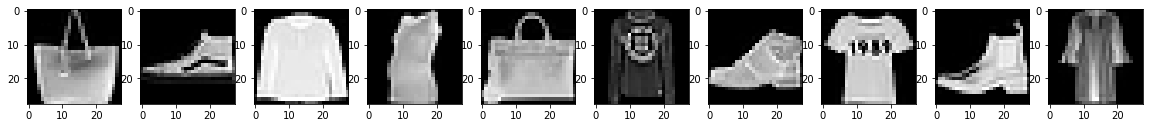

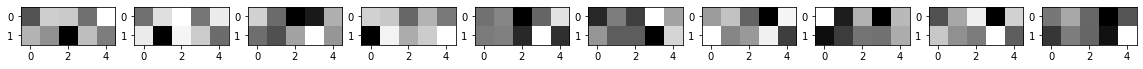

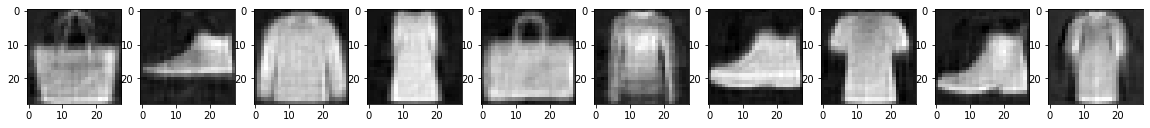

In [8]:
#images originales
from PIL import Image 
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(test_x[i].reshape(28, 28),cmap='gray')
plt.show()

#visualisation du latent space
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds_latent[i].reshape(2, 5),cmap='gray')
plt.show()

#visualisation
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28),cmap='gray')
plt.show()

Visualisons à présent l'espace latent de dimension 10 dans un espace de dimension 2 obtenu par T-SNE: pour visualiser à quoi ressemble un espace latent.

In [9]:
from sklearn.manifold import TSNE

preds_latent = encoder.predict(train_x)

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(preds_latent)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.010s...
[t-SNE] Computed neighbors for 8000 samples in 0.693s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.065752
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.216141
[t-SNE] KL divergence after 300 iterations: 3.366845


In [10]:
# Utility function
lab = ["t-shirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle boot"]

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(lab[i]), fontsize=25)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(-7.3218613, 5.4146786, 't-shirt'),
  Text(-8.585272, -5.360249, 'trouser'),
  Text(1.7379708, 5.9898076, 'pullover'),
  Text(-5.504224, 0.3476912, 'dress'),
  Text(0.10017669, 7.64804, 'coat'),
  Text(4.6226225, -4.068381, 'sandal'),
  Text(-0.13330543, 4.187276, 'shirt'),
  Text(8.594406, -5.7797723, 'sneaker'),
  Text(5.3857803, 0.16099694, 'bag'),
  Text(0.3537103, -9.680842, 'ankle boot')])

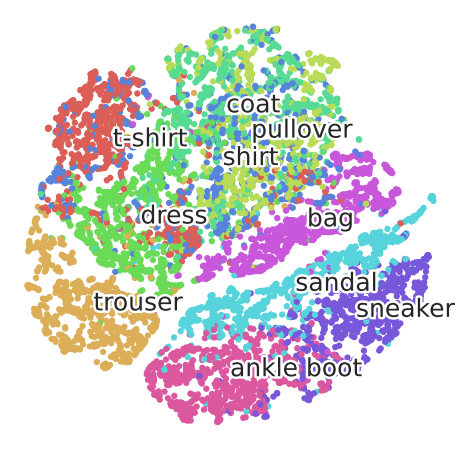

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline



import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(train_y, dtype=np.float32)
fashion_scatter(tsne_results, train_y)

Ici, nous avons fixé la taille de l'espace latent (10 dimensions). Si nous cartographions les 60 000 images de FashionMnist dans l'espace latent, chacune des 10 classes du jeu de données se regrouperaient dans une hyperellipsoïde de 10 dimensions. Vous pouvez vous amuser à augmenter drastiquement la taille de l'espace latent pour avoir de meilleurs résultats.

Vous pouvez déjà remarquer que les clusters de chaque classes sont assez cohérents: les chaussures se retrouvent d'un coté (sandal, sneaker, ankle boot), les sacs et les pantalons sont plutôt bien séparés des autres exemples et les habits du haut du corps (ceux dont la variance inter classe est la moindre) restent assez regroupés.



Si nous souhaitons générer une nouvelle image d'une certaine classe, nous pouvons choisir un nouveau point aléatoire (différent des points d'images existantes) à l'intérieur de l'ellipsoïde d'une classe pour le décoder ensuite.

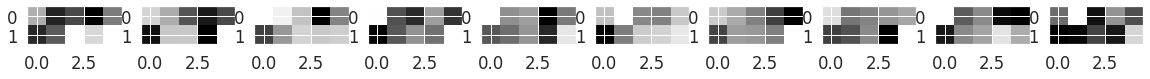

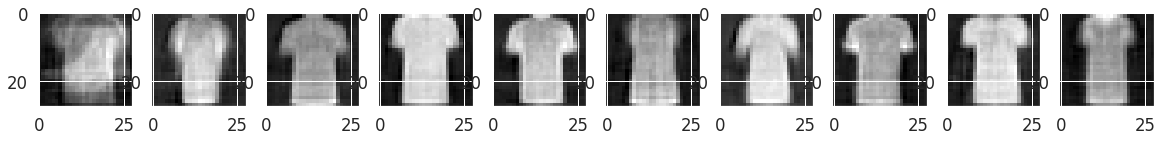

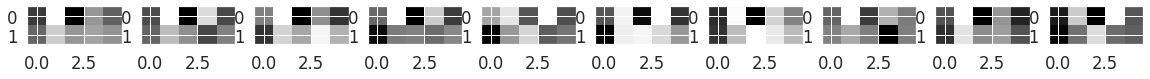

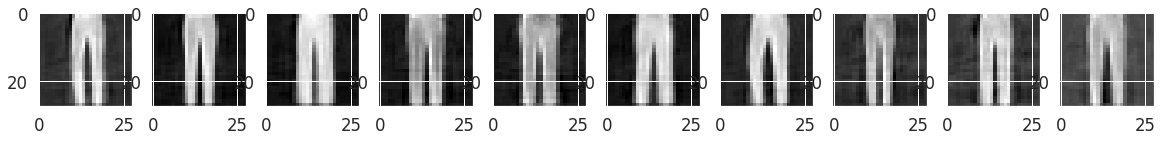

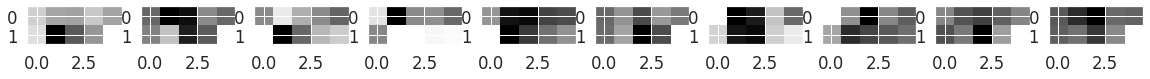

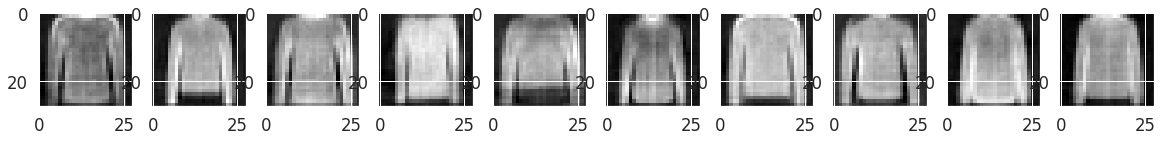

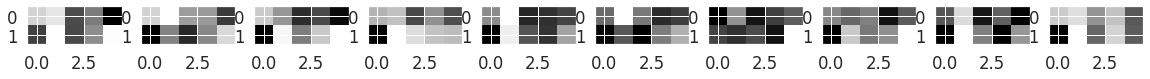

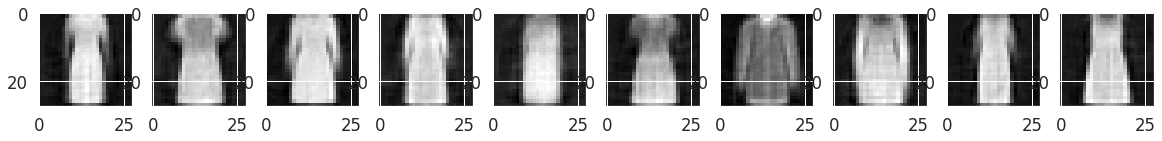

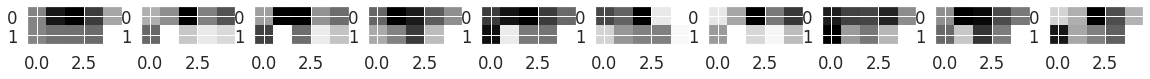

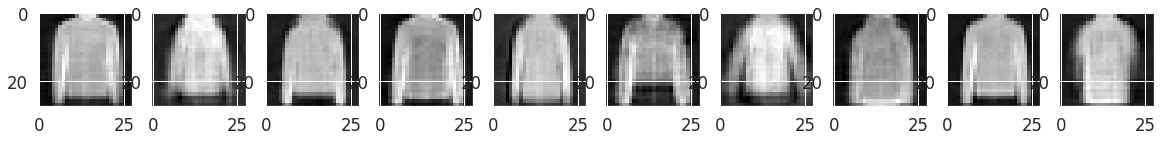

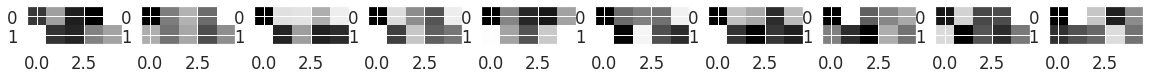

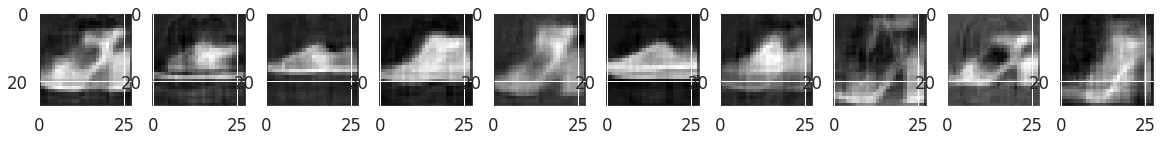

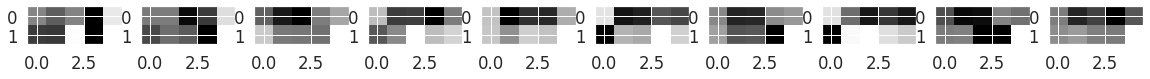

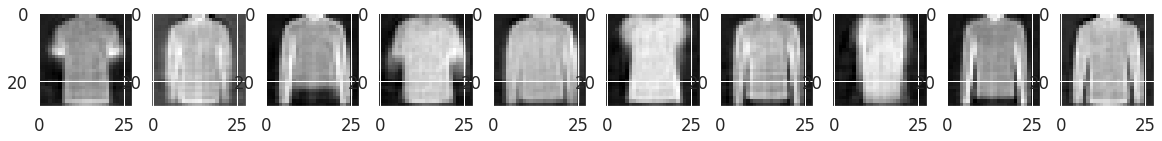

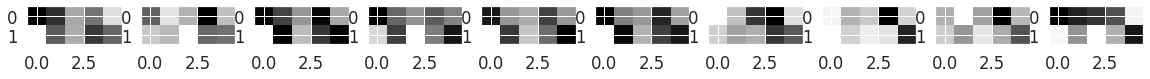

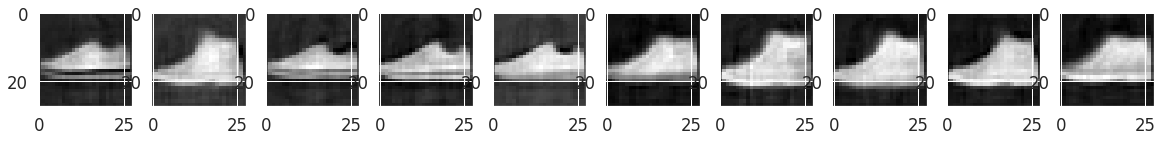

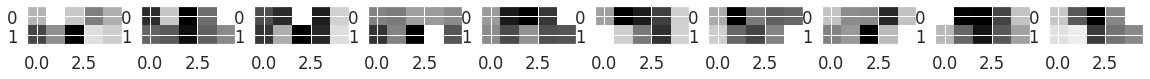

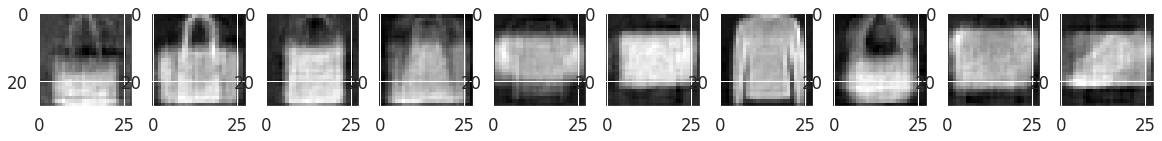

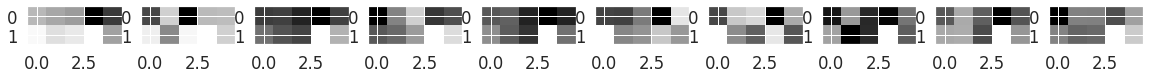

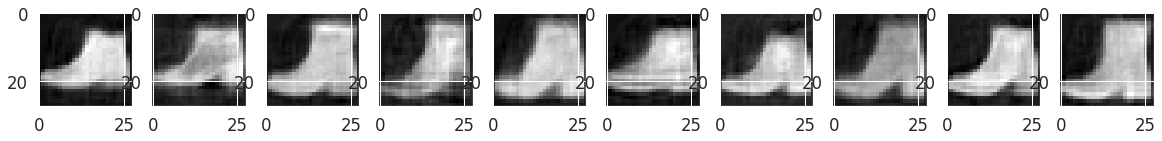

In [12]:
# CREATE 10 IMAGES for each classes;
for nb_classes in range(10):
  sub_train = np.where(train_y == nb_classes)
  images = train_x[sub_train]

          
  # CALCULATE ELLIPSOID FROM IMAGES        
  encoded_imgs = encoder.predict(images)
  sz = 2*5
  encoded_imgs = encoded_imgs.reshape((-1,sz))
  mm = np.mean(encoded_imgs,axis=0)
  ss = np.cov(encoded_imgs,rowvar=False)

  # GENERATE 10 RANDOM IMAGES
  generated = np.random.multivariate_normal(mm,ss,10)

  # PLOT 10 RANDOM IMAGES

  #visualisation du latent space
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  for i in range(10):
      ax[i].imshow(generated[i].reshape(2, 5),cmap='gray')
  plt.show()

  #visualisation reconstruction
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  reconstruct = decoder.predict(generated)
  for i in range(10):
      ax[i].imshow(reconstruct[i].reshape(28, 28),cmap='gray')
  plt.show()


## AutoEncoder Convolutif: avant de passer à cette étape, relancez l'auto-encodeur dense avec un espace latent de dimension 30+

In [13]:
# input layer
input_layer = Input(shape=(28, 28, 1))

#NB dimension
latent_dim = 10

x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
latent = Dense(latent_dim, name="latent")(x)
direct_input = Input(shape=latent_dim)

decoded = Dense(7 * 7* 32, activation="relu")(direct_input)
x = Reshape((7, 7, 32))(decoded)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)



encoder = Model(input_layer, latent)
decoder = Model(direct_input, decoder_outputs)
model = Model(input_layer, decoder(latent))

model.summary()
decoder.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
latent (Dense)               (None, 10)                1569

In [14]:
model.compile(optimizer='adam', loss='mse')
train_x2 = train_x.reshape(-1, 28, 28, 1)
val_x2 = test_x.reshape(-1, 28, 28, 1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, min_lr=1e-10)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

history = model.fit(train_x2, train_x2,validation_data=(val_x2, val_x2), epochs=400, batch_size=32, callbacks=[early_stopping,reduce_lr])

Epoch 1/400
250/250 [==============================] - 7s 5ms/step - loss: 0.0630 - val_loss: 0.1345
Epoch 2/400
250/250 [==============================] - 1s 4ms/step - loss: 0.0222 - val_loss: 0.0260
Epoch 3/400
250/250 [==============================] - 1s 4ms/step - loss: 0.0190 - val_loss: 0.0198
Epoch 4/400
250/250 [==============================] - 1s 4ms/step - loss: 0.0180 - val_loss: 0.0192
Epoch 5/400
250/250 [==============================] - 1s 4ms/step - loss: 0.0169 - val_loss: 0.0179
Epoch 6/400
250/250 [==============================] - 1s 4ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 7/400
250/250 [==============================] - 1s 4ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 8/400
250/250 [==============================] - 1s 4ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 9/400
250/250 [==============================] - 1s 4ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 10/400
250/250 [==============================] - 1s 4ms/step - loss: 0.0146 - val_lo

In [15]:
preds = model.predict(train_x2)
preds_latent = encoder.predict(train_x2)

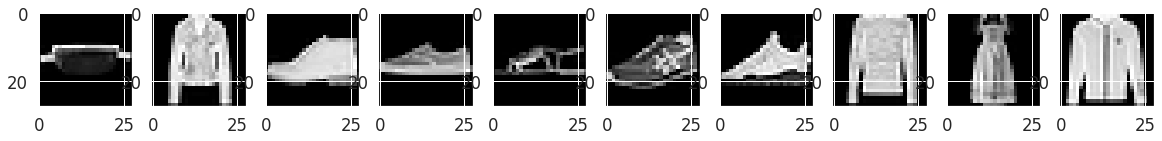

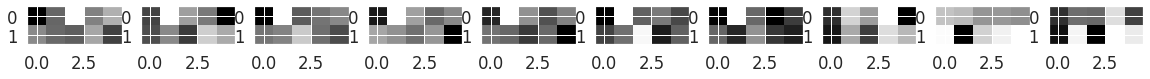

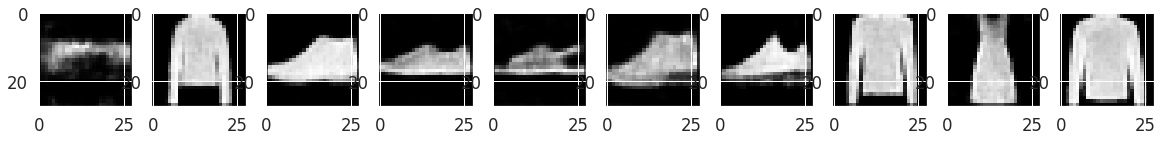

In [16]:
#images originales
from PIL import Image 
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(train_x2[i].reshape(28, 28),cmap='gray')
plt.show()

#visualisation du latent space
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds_latent[i].reshape(2, 5),cmap='gray')
plt.show()

#visualisation
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28),cmap='gray')
plt.show()

In [17]:
from sklearn.manifold import TSNE

preds_latent = encoder.predict(train_x2)

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(preds_latent)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.009s...
[t-SNE] Computed neighbors for 8000 samples in 0.454s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 3.934121
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.409081
[t-SNE] KL divergence after 300 iterations: 3.272846


(<Figure size 576x576 with 1 Axes>,
 [Text(0.31664672, 9.673468, 't-shirt'),
  Text(-9.94059, 1.298607, 'trouser'),
  Text(6.618709, 1.4859895, 'pullover'),
  Text(-5.131231, 6.317688, 'dress'),
  Text(4.465561, 0.052135944, 'coat'),
  Text(-0.39343828, -5.103707, 'sandal'),
  Text(3.1309714, 4.1643467, 'shirt'),
  Text(4.036065, -9.500346, 'sneaker'),
  Text(-0.037352715, -0.814531, 'bag'),
  Text(-5.8986287, -8.692572, 'ankle boot')])

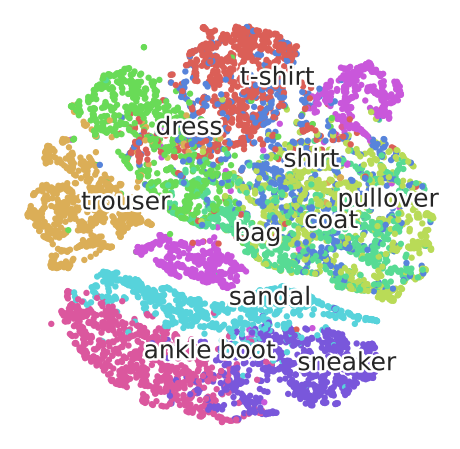

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline



import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(train_y, dtype=np.float32)
fashion_scatter(tsne_results, train_y)

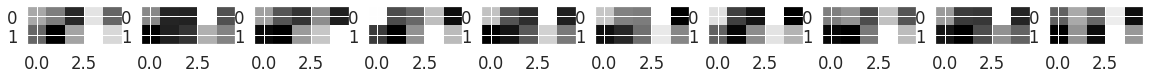

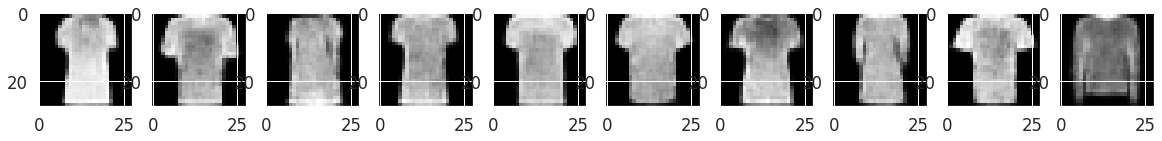

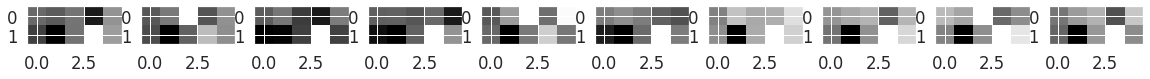

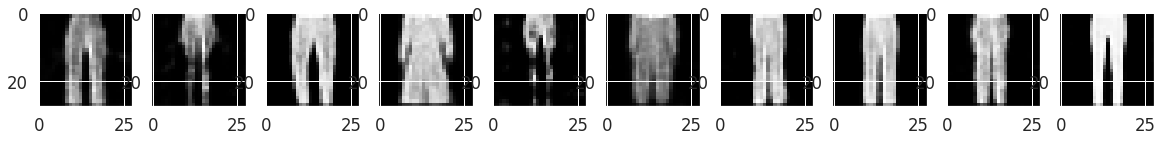

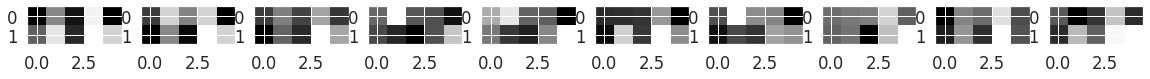

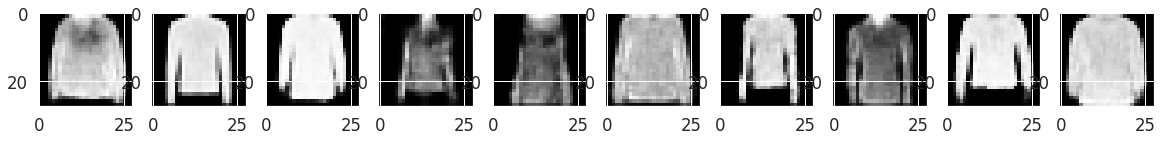

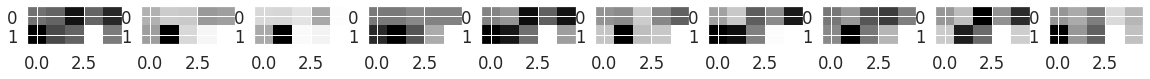

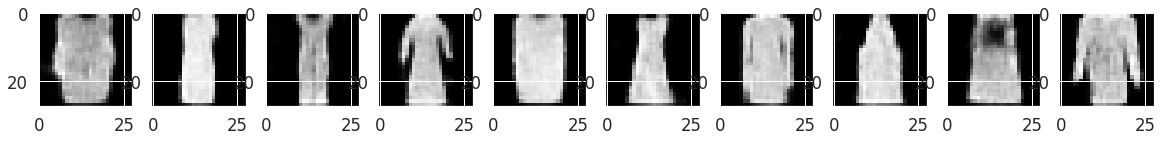

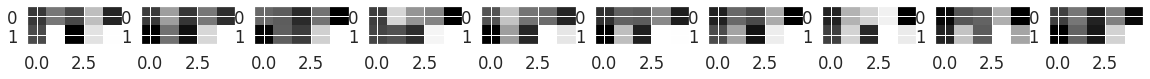

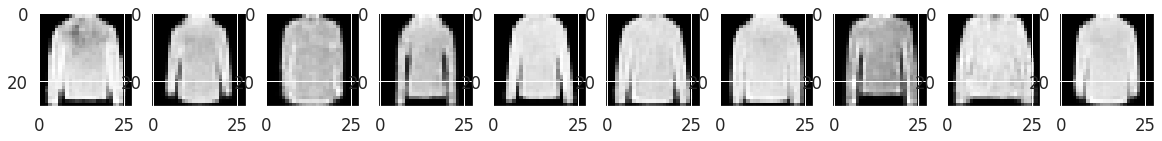

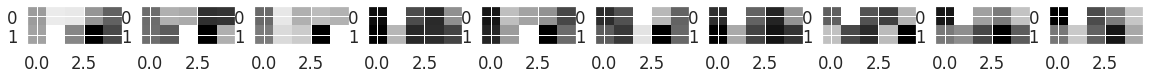

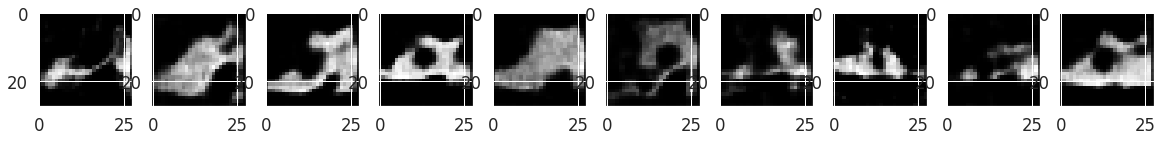

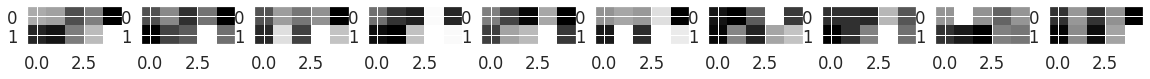

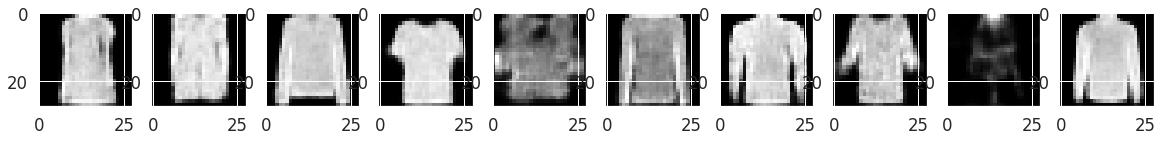

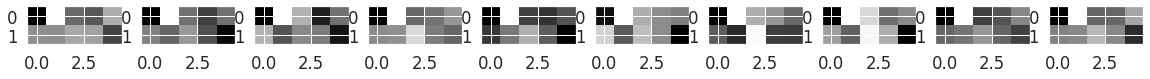

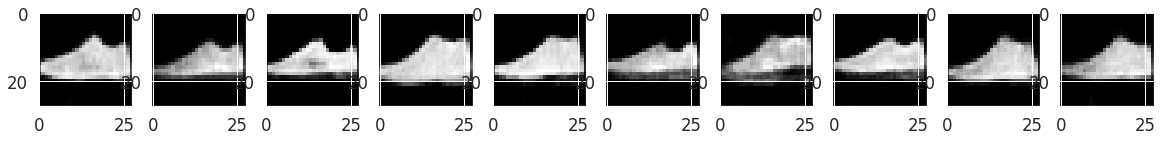

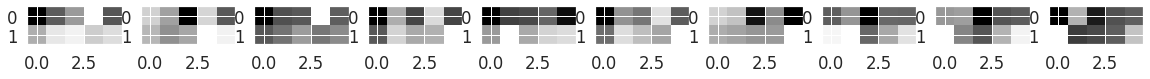

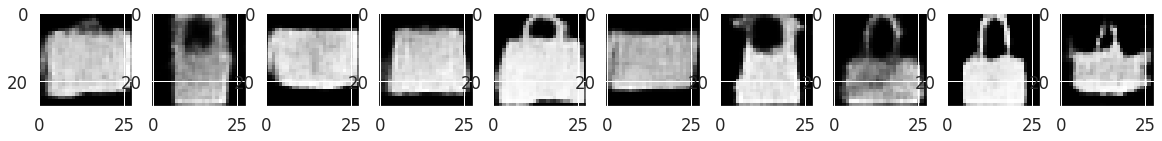

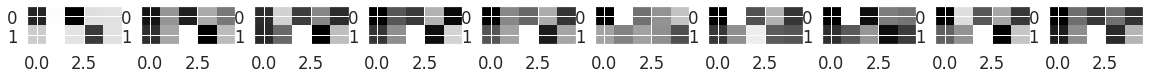

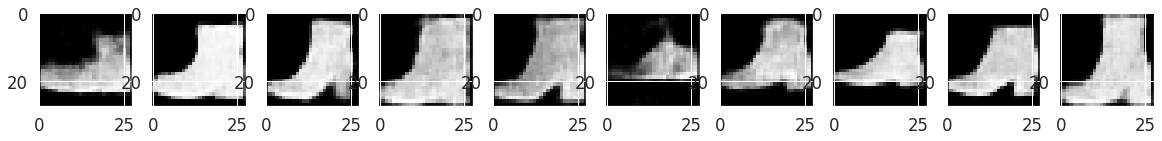

In [19]:
# CREATE 10 IMAGES for each classes;
for nb_classes in range(10):
  sub_train = np.where(train_y == nb_classes)
  images = train_x2[sub_train]

          
  # CALCULATE ELLIPSOID FROM IMAGES        
  encoded_imgs = encoder.predict(images)
  sz = 2*5
  encoded_imgs = encoded_imgs.reshape((-1,sz))
  mm = np.mean(encoded_imgs,axis=0)
  ss = np.cov(encoded_imgs,rowvar=False)

  # GENERATE 10 RANDOM IMAGES
  generated = np.random.multivariate_normal(mm,ss,10)

  # PLOT 10 RANDOM IMAGES

  #visualisation du latent space
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  for i in range(10):
      ax[i].imshow(generated[i].reshape(2, 5),cmap='gray')
  plt.show()

  #visualisation reconstruction
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  reconstruct = decoder.predict(generated)
  for i in range(10):
      ax[i].imshow(reconstruct[i].reshape(28, 28),cmap='gray')
  plt.show()


##Générer des images un peu plus intéréssantes:
Au lieu de choisir des points complètement aléatoires en fonction de la distribution des classes dans l'espace latent, il existe plusieurs manières de générer des points: combinaisons linéaires de plusieurs points, choisir des points proches des images d'entraînement existantes... Laissez parler votre imagination.

Dans notre cas, on rajoute une contrainte de proximité des points générés avec les images initiales:

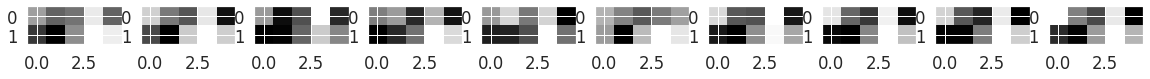

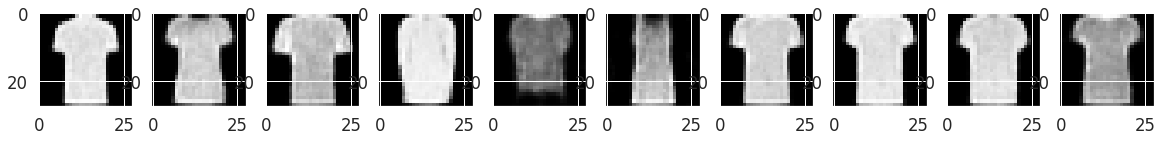

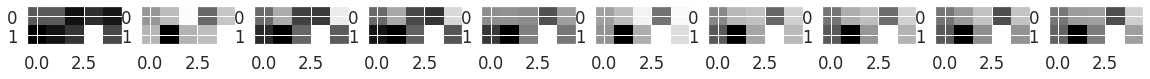

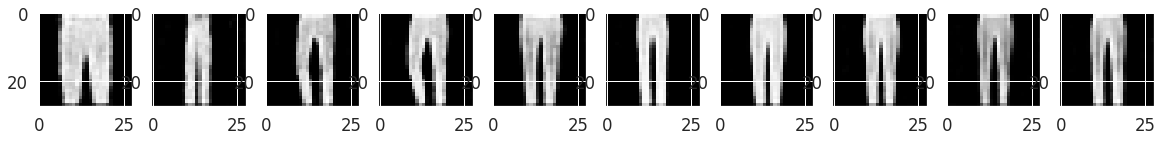

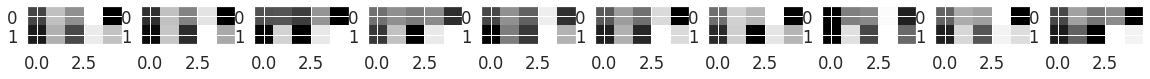

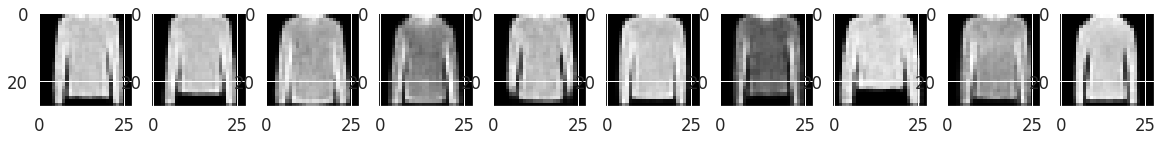

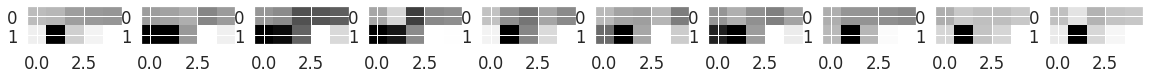

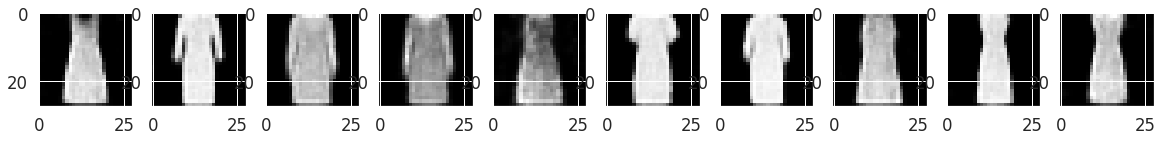

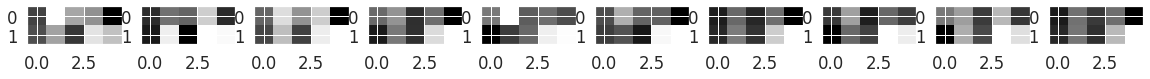

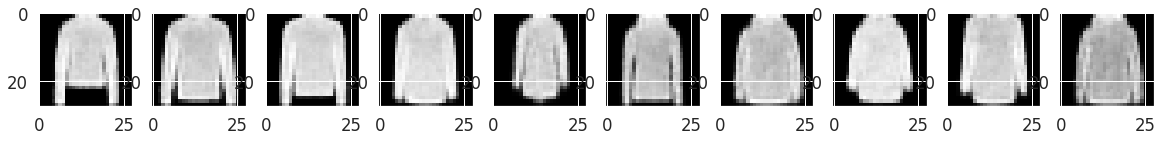

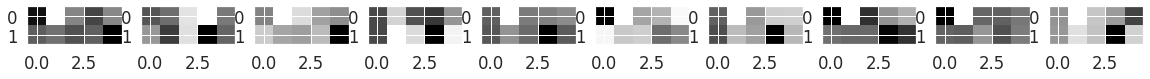

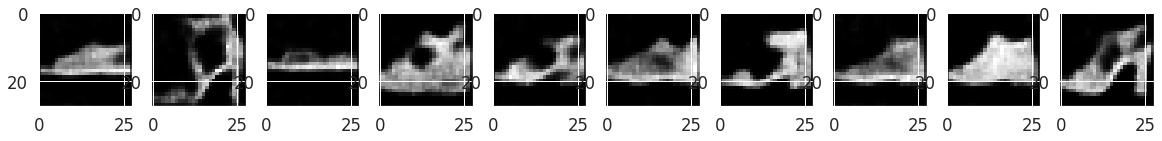

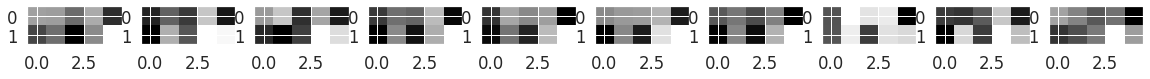

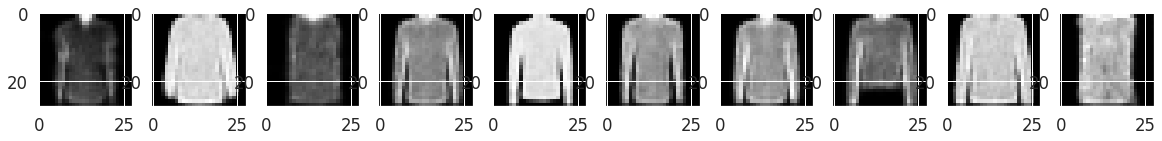

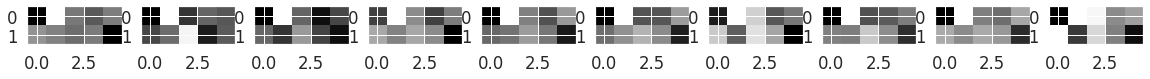

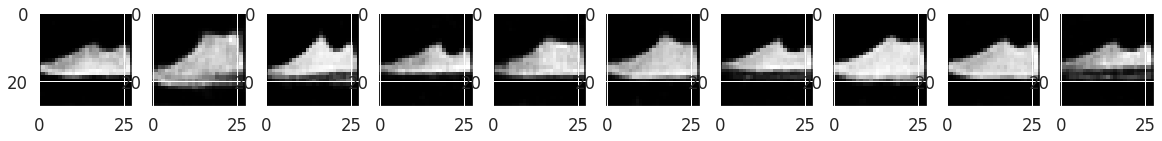

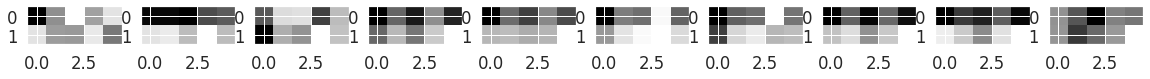

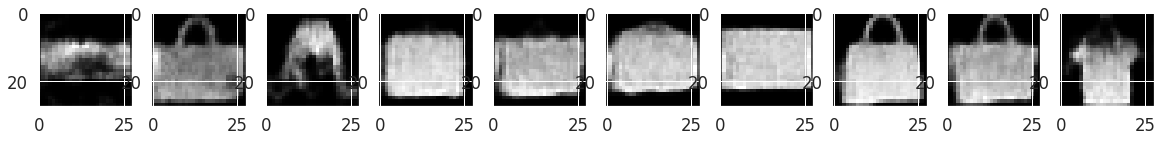

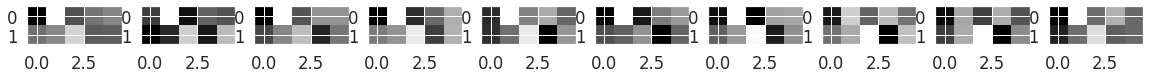

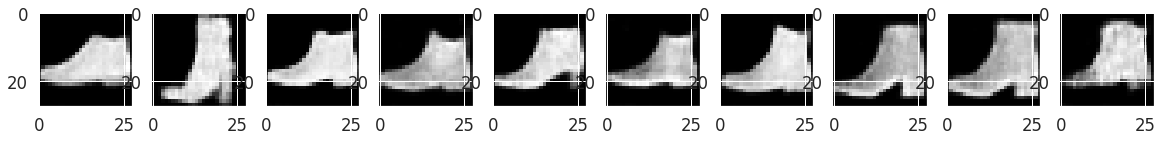

In [20]:
for nb_classes in range(10):
  sub_train = np.where(train_y == nb_classes)
  images = train_x2[sub_train]

          
  # CALCULATE ELLIPSOID FROM IMAGES        
  encoded_imgs = encoder.predict(images)
  sz = 2*5
  encoded_imgs = encoded_imgs.reshape((-1,sz))
  mm = np.mean(encoded_imgs,axis=0)
  ss = np.cov(encoded_imgs,rowvar=False)


  # DISTANCE TO MOVE AWAY FROM EXISTING TRAIN IMAGES
  beta = 0.2
  # GENERATE 10 Random Images in latent space
  generated = np.random.multivariate_normal(mm,ss,10)
  generated = beta*generated + (1-beta)*encoded_imgs[:10]

  # PLOT 10 RANDOM IMAGES

  #visualisation du latent space
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  for i in range(10):
      ax[i].imshow(generated[i].reshape(2, 5),cmap='gray')
  plt.show()

  #visualisation reconstruction
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  reconstruct = decoder.predict(generated)
  for i in range(10):
      ax[i].imshow(reconstruct[i].reshape(28, 28),cmap='gray')
  plt.show()

# Partie 2: denoising AE
Différentes techniques existent pour empêcher un AE d'apprendre la fonction identité afin d'améliorer sa capacité à apprendre des représentations plus riches: en obligeant l'espace latent à avoir un petit nombre de neurones, on force le réseau à apprendre une représentation intelligente des données. Il existe d'autres façon de forcer le réseau à apprendre une bonne représentation: en ajoutant du bruit aléatoire à nos données d'entrées pour récupérer l'image originale sans ce bruit.

De cette façon, l'AE ne peut pas simplement copier l'entrée et sa sortie car l'entrée est bruitée, on lui demande alors de soustraire le bruit et de comprendre les données sous jacentes: c'est le denoising AE.

In [21]:
from imgaug import augmenters
# Lets add sample noise - Salt and Pepper
noise = augmenters.ImpulseNoise(0.3)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x2 * 255) / 255
val_x_n = seq_object.augment_images(val_x2 * 255) / 255

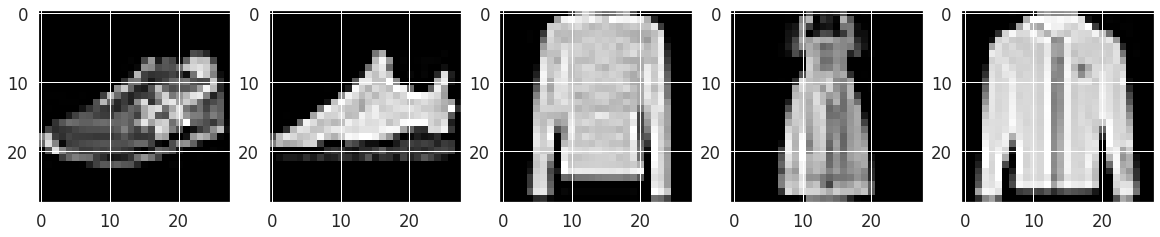

In [22]:
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28),cmap='gray')
plt.show()

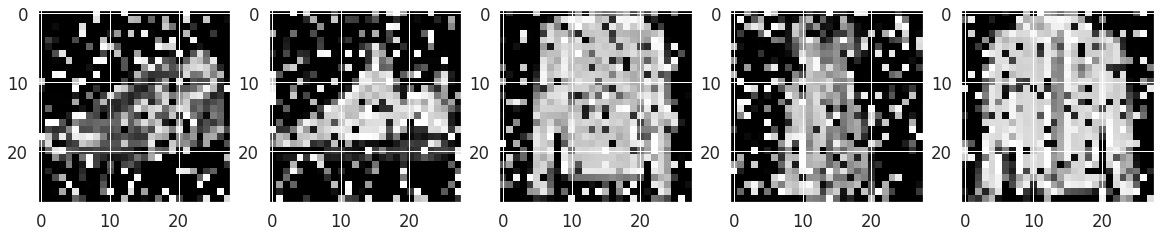

In [23]:
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28),cmap='gray')
plt.show()

**Reimplémentez un AutoEncoder Convolutif** et entrainez le sur ces données bruitées, en suivant le même format, visualisez l'espace latent obtenu, visualisez la reconstruction de votre autoencoder et générez de nouvelles données: essayez avec un espace latent de taille conséquente: 30+

Vous pouvez également vous amuser à faire varier le type de bruit que l'on ajoute aux images en suivant la doc: https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html

In [24]:
#votre code

In [25]:
#votre code

In [26]:
#votre code

In [27]:
#votre code

# Partie 3: Variational AE
Selon l'exemple: https://keras.io/examples/generative/vae/ , implémentez un variational AutoEncoder et affichez les exemples générés sur FashionMnist

#Partie 4: GANs

**Generative Adversarial Networks** (GANs) ; jeu d'imitation joué par un générateur G et un discriminateur D.
Vous allez découvrir :
* le cadre original des GAN proposé par [GoodFellow et al. en 2014] (https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)
* quelques techniques de base pour réduire le mode collapse tout en améliorant la qualité et la vitesse de convergence des exemples générés


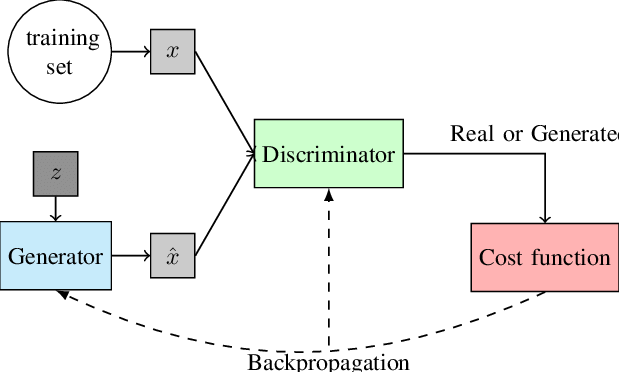


Les GANs se composent de deux éléments:


*   Générateur - génère de nouvelles instances de données
*   Discriminateur - tente de distinguer les données générées ou fausses du jeu de données réel.

##Pincipe

Le Générateur est alimenté par du bruit sous la forme d'une distribution aléatoire et qui génère de fausses données à partir de ce bruit. Les données falsifiées du générateur sont entrées dans le discriminateur. Une fois l'entrainement terminée, le générateur devrait être capable de générer des données réelles à partir du bruit.

Le discriminateur devient l'adversaire du générateur. Il s'agit essentiellement d'un classificateur ou d'un discriminateur dont la fonction est de distinguer deux classes différentes de données. Dans ce cas, les classes sont les données réelles (désignées par 1) et les fausses données produites par le générateur (désignées par 0).


Le fait intéressant de l'approche réside dans le fait que le générateur apprend à produire des images significatives sans même avoir vu une seule fois les images réelles.

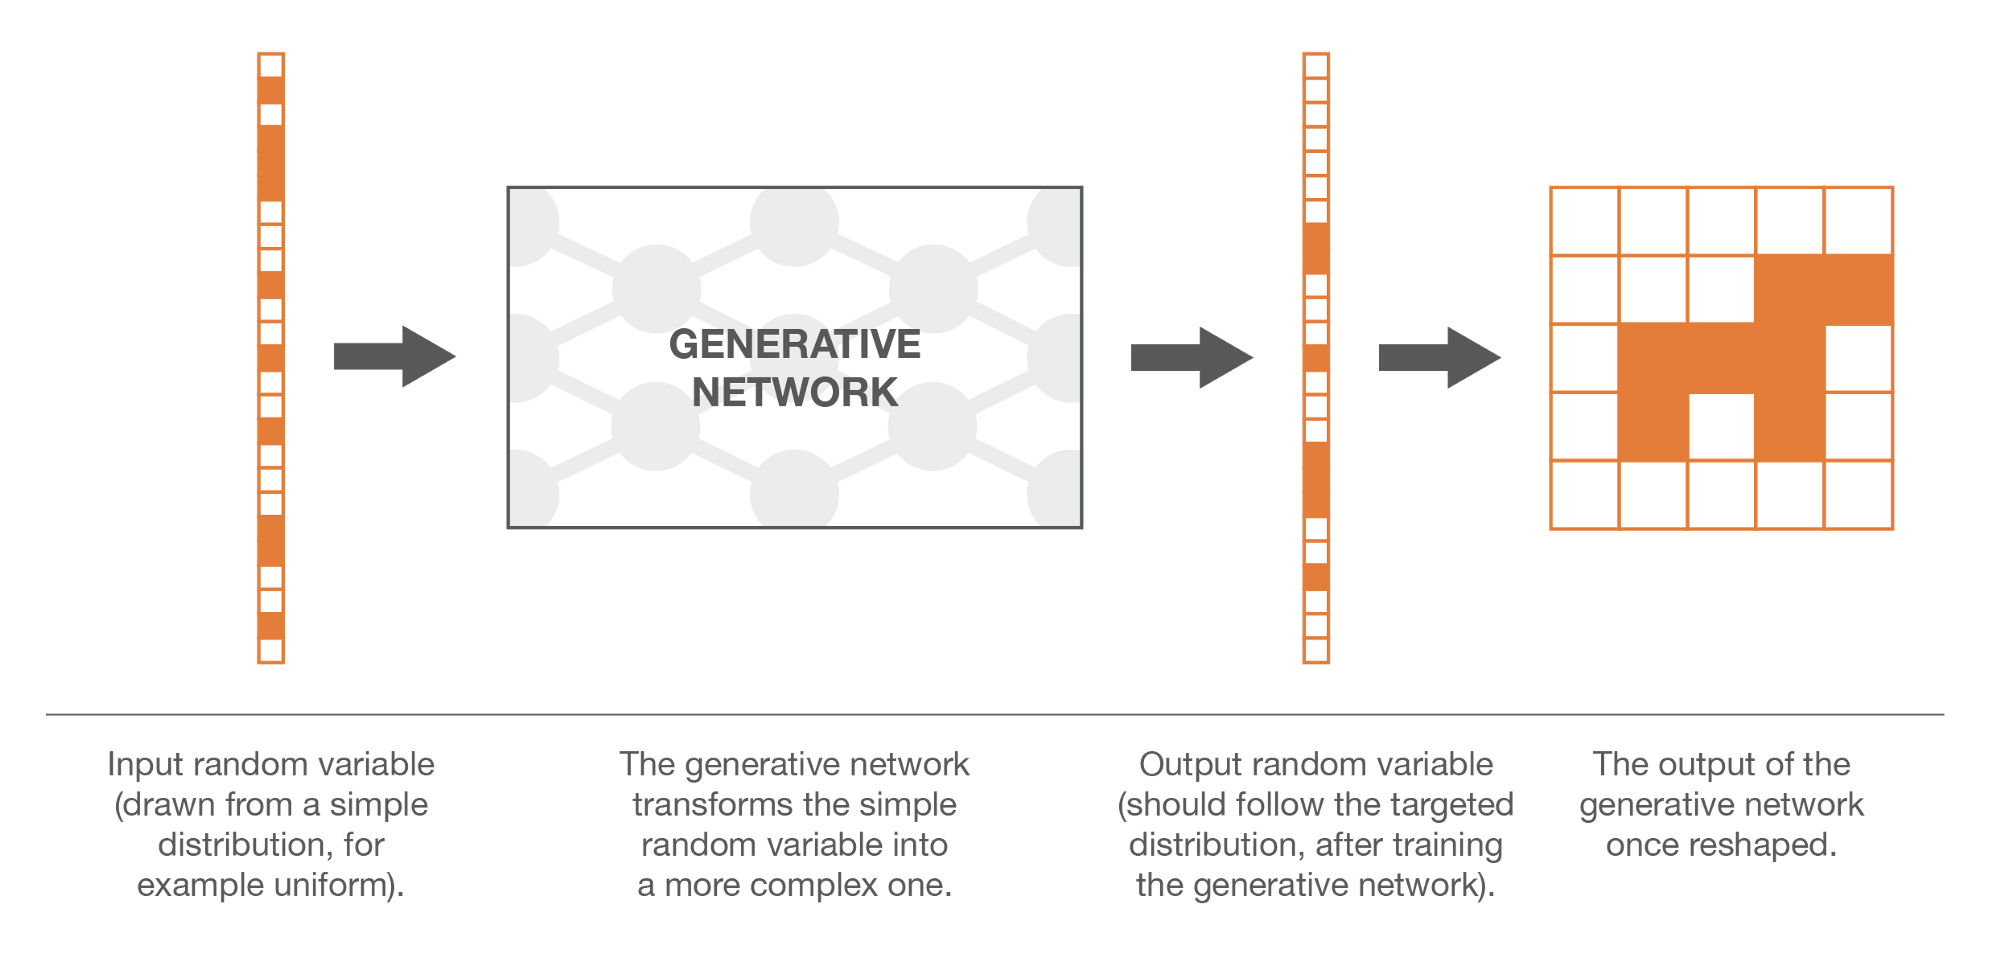

##Problèmes des GANs Classiques et implémentation

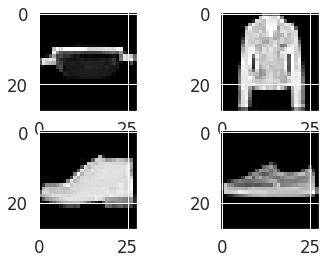

In [28]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(train_x[idx].reshape(28,28),cmap='gray')
        idx+=1


Modele Gan Simple (dense)

In [31]:
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

In [32]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               51712     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_15 (Dense)             (None, 128)              

In [33]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [34]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 28, 28, 1)         2         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)              

In [35]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [36]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')
GAN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         320656    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 242179    
Total params: 562,835
Trainable params: 318,864
Non-trainable params: 243,971
_________________________________________________________________


In [46]:
epochs = 120
batch_size = 100
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 80


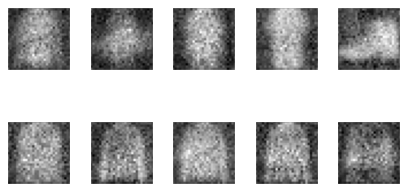

Currently on Epoch 2
	Currently on batch number 50 of 80
Currently on Epoch 3
	Currently on batch number 50 of 80
Currently on Epoch 4
	Currently on batch number 50 of 80
Currently on Epoch 5
	Currently on batch number 50 of 80
Currently on Epoch 6
	Currently on batch number 50 of 80


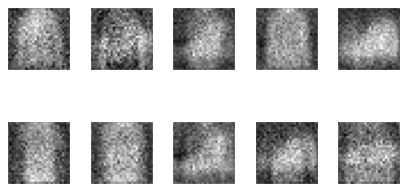

Currently on Epoch 7
	Currently on batch number 50 of 80
Currently on Epoch 8
	Currently on batch number 50 of 80
Currently on Epoch 9
	Currently on batch number 50 of 80
Currently on Epoch 10
	Currently on batch number 50 of 80
Currently on Epoch 11
	Currently on batch number 50 of 80


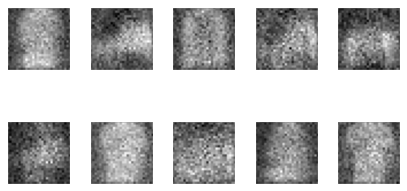

Currently on Epoch 12
	Currently on batch number 50 of 80
Currently on Epoch 13
	Currently on batch number 50 of 80
Currently on Epoch 14
	Currently on batch number 50 of 80
Currently on Epoch 15
	Currently on batch number 50 of 80
Currently on Epoch 16
	Currently on batch number 50 of 80


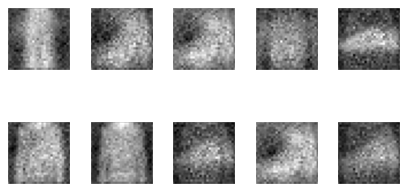

Currently on Epoch 17
	Currently on batch number 50 of 80
Currently on Epoch 18
	Currently on batch number 50 of 80
Currently on Epoch 19
	Currently on batch number 50 of 80
Currently on Epoch 20
	Currently on batch number 50 of 80
Currently on Epoch 21
	Currently on batch number 50 of 80


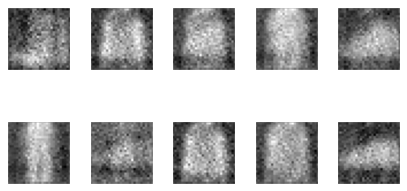

Currently on Epoch 22
	Currently on batch number 50 of 80
Currently on Epoch 23
	Currently on batch number 50 of 80
Currently on Epoch 24
	Currently on batch number 50 of 80
Currently on Epoch 25
	Currently on batch number 50 of 80
Currently on Epoch 26
	Currently on batch number 50 of 80


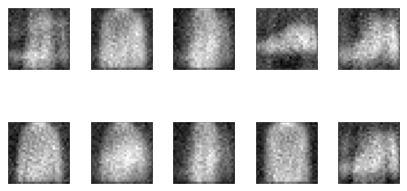

Currently on Epoch 27
	Currently on batch number 50 of 80
Currently on Epoch 28
	Currently on batch number 50 of 80
Currently on Epoch 29
	Currently on batch number 50 of 80
Currently on Epoch 30
	Currently on batch number 50 of 80
Currently on Epoch 31
	Currently on batch number 50 of 80


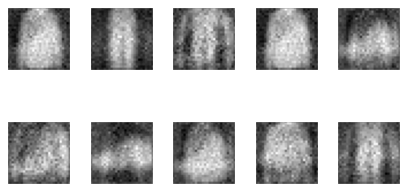

Currently on Epoch 32
	Currently on batch number 50 of 80
Currently on Epoch 33
	Currently on batch number 50 of 80
Currently on Epoch 34
	Currently on batch number 50 of 80
Currently on Epoch 35
	Currently on batch number 50 of 80
Currently on Epoch 36
	Currently on batch number 50 of 80


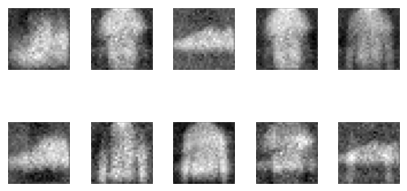

Currently on Epoch 37
	Currently on batch number 50 of 80
Currently on Epoch 38
	Currently on batch number 50 of 80
Currently on Epoch 39
	Currently on batch number 50 of 80
Currently on Epoch 40
	Currently on batch number 50 of 80
Currently on Epoch 41
	Currently on batch number 50 of 80


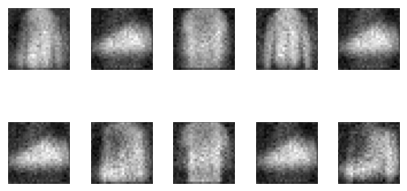

Currently on Epoch 42
	Currently on batch number 50 of 80
Currently on Epoch 43
	Currently on batch number 50 of 80
Currently on Epoch 44
	Currently on batch number 50 of 80
Currently on Epoch 45
	Currently on batch number 50 of 80
Currently on Epoch 46
	Currently on batch number 50 of 80


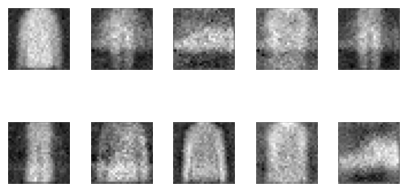

Currently on Epoch 47
	Currently on batch number 50 of 80
Currently on Epoch 48
	Currently on batch number 50 of 80
Currently on Epoch 49
	Currently on batch number 50 of 80
Currently on Epoch 50
	Currently on batch number 50 of 80
Currently on Epoch 51
	Currently on batch number 50 of 80


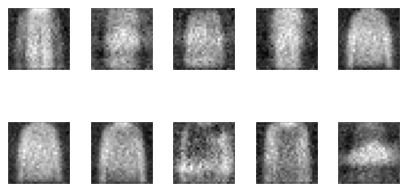

Currently on Epoch 52
	Currently on batch number 50 of 80
Currently on Epoch 53
	Currently on batch number 50 of 80
Currently on Epoch 54
	Currently on batch number 50 of 80
Currently on Epoch 55
	Currently on batch number 50 of 80
Currently on Epoch 56
	Currently on batch number 50 of 80


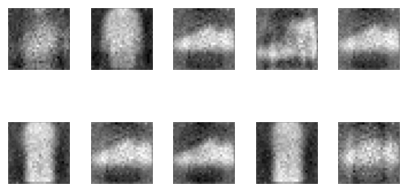

Currently on Epoch 57
	Currently on batch number 50 of 80
Currently on Epoch 58
	Currently on batch number 50 of 80
Currently on Epoch 59
	Currently on batch number 50 of 80
Currently on Epoch 60
	Currently on batch number 50 of 80
Currently on Epoch 61
	Currently on batch number 50 of 80


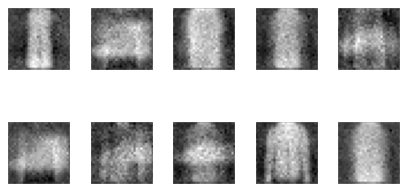

Currently on Epoch 62
	Currently on batch number 50 of 80
Currently on Epoch 63
	Currently on batch number 50 of 80
Currently on Epoch 64
	Currently on batch number 50 of 80
Currently on Epoch 65
	Currently on batch number 50 of 80
Currently on Epoch 66
	Currently on batch number 50 of 80


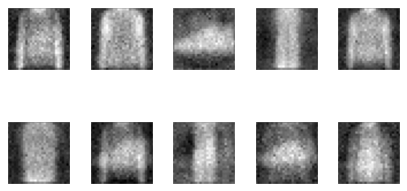

Currently on Epoch 67
	Currently on batch number 50 of 80
Currently on Epoch 68
	Currently on batch number 50 of 80
Currently on Epoch 69
	Currently on batch number 50 of 80
Currently on Epoch 70
	Currently on batch number 50 of 80
Currently on Epoch 71
	Currently on batch number 50 of 80


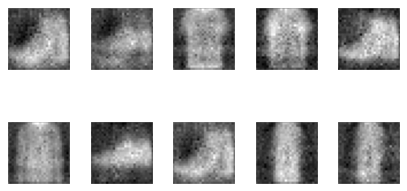

Currently on Epoch 72
	Currently on batch number 50 of 80
Currently on Epoch 73
	Currently on batch number 50 of 80
Currently on Epoch 74
	Currently on batch number 50 of 80
Currently on Epoch 75
	Currently on batch number 50 of 80
Currently on Epoch 76
	Currently on batch number 50 of 80


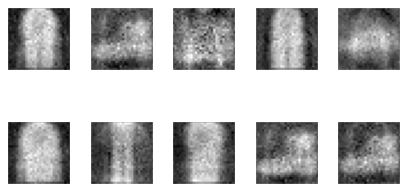

Currently on Epoch 77
	Currently on batch number 50 of 80
Currently on Epoch 78
	Currently on batch number 50 of 80
Currently on Epoch 79
	Currently on batch number 50 of 80
Currently on Epoch 80
	Currently on batch number 50 of 80
Currently on Epoch 81
	Currently on batch number 50 of 80


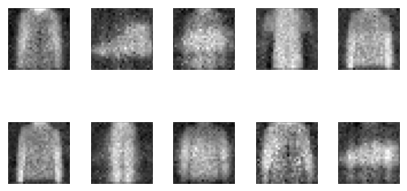

Currently on Epoch 82
	Currently on batch number 50 of 80
Currently on Epoch 83
	Currently on batch number 50 of 80
Currently on Epoch 84
	Currently on batch number 50 of 80
Currently on Epoch 85
	Currently on batch number 50 of 80
Currently on Epoch 86
	Currently on batch number 50 of 80


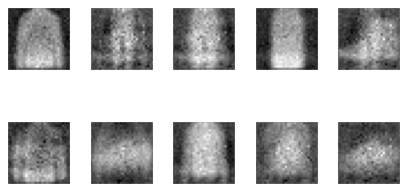

Currently on Epoch 87
	Currently on batch number 50 of 80
Currently on Epoch 88
	Currently on batch number 50 of 80
Currently on Epoch 89
	Currently on batch number 50 of 80
Currently on Epoch 90
	Currently on batch number 50 of 80
Currently on Epoch 91
	Currently on batch number 50 of 80


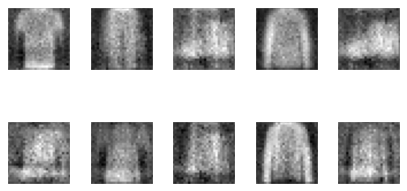

Currently on Epoch 92
	Currently on batch number 50 of 80
Currently on Epoch 93
	Currently on batch number 50 of 80
Currently on Epoch 94
	Currently on batch number 50 of 80
Currently on Epoch 95
	Currently on batch number 50 of 80
Currently on Epoch 96
	Currently on batch number 50 of 80


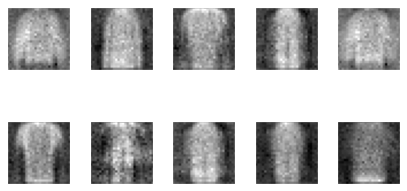

Currently on Epoch 97
	Currently on batch number 50 of 80
Currently on Epoch 98
	Currently on batch number 50 of 80
Currently on Epoch 99
	Currently on batch number 50 of 80
Currently on Epoch 100
	Currently on batch number 50 of 80
Currently on Epoch 101
	Currently on batch number 50 of 80


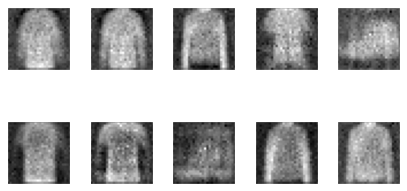

Currently on Epoch 102
	Currently on batch number 50 of 80
Currently on Epoch 103
	Currently on batch number 50 of 80
Currently on Epoch 104
	Currently on batch number 50 of 80
Currently on Epoch 105
	Currently on batch number 50 of 80
Currently on Epoch 106
	Currently on batch number 50 of 80


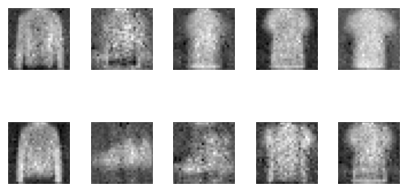

Currently on Epoch 107
	Currently on batch number 50 of 80
Currently on Epoch 108
	Currently on batch number 50 of 80
Currently on Epoch 109
	Currently on batch number 50 of 80
Currently on Epoch 110
	Currently on batch number 50 of 80
Currently on Epoch 111
	Currently on batch number 50 of 80


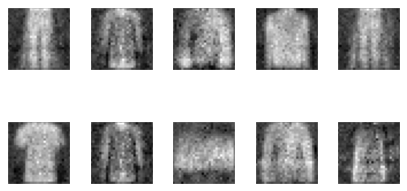

Currently on Epoch 112
	Currently on batch number 50 of 80
Currently on Epoch 113
	Currently on batch number 50 of 80
Currently on Epoch 114
	Currently on batch number 50 of 80
Currently on Epoch 115
	Currently on batch number 50 of 80
Currently on Epoch 116
	Currently on batch number 50 of 80


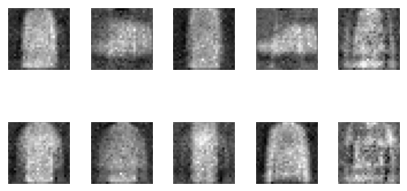

Currently on Epoch 117
	Currently on batch number 50 of 80
Currently on Epoch 118
	Currently on batch number 50 of 80
Currently on Epoch 119
	Currently on batch number 50 of 80
Currently on Epoch 120
	Currently on batch number 50 of 80
Training is complete


In [47]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    
    for i in range(train_x2.shape[0]//batch_size):
        
        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {train_x2.shape[0]//batch_size}")
            
        noise=np.random.normal(size=[batch_size,noise_shape])
       
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = train_x2[i*batch_size:(i+1)*batch_size]
       
        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        
        #training generator 
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
        
        
        
       
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 5 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')

In [48]:
noise=np.random.normal(size=[10,noise_shape])

gen_image = generator.predict(noise)

Text(0.5, 1.0, 'How the noise looks')

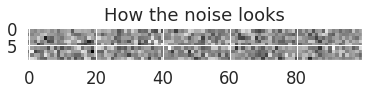

In [49]:
plt.imshow(noise, cmap='gray')
plt.title('How the noise looks')

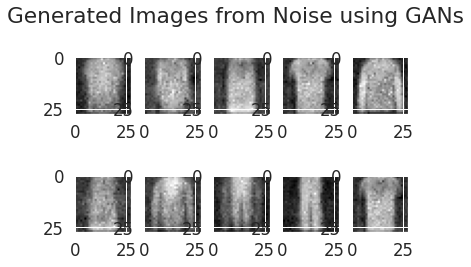

In [50]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

Dans la pratique, les GANS souffrent de nombreux problèmes, notamment pendant l'entrainement. Un problème courant consiste à faire s'effondrer le générateur pour au final ne produire qu'un seul échantillon ou une petite famille d'échantillons très similaires (comme vous le remarquez ici). Dans ce cas, le générateur apprend à tromper le discriminateur avec une seule image ou quelques images à croire qu'il s'agit d'une image réelle. Un autre mode implique que le générateur et le discriminateur oscillent pendant l'entraînement, plutôt que de converger vers un point fixe. En outre, si un agent devient beaucoup plus puissant que l'autre, le signal d'apprentissage de l'autre agent devient inutile, et le système n'apprend pas. Pour entrainer les GANs, il faut utiliser de nombreuses astuces, l'une d'entre elles étant l'utilisation de réseaux adversatifs générateurs à convolution deep: https://arxiv.org/abs/1511.06434

##Implementation

D'après la ressource suivante: https://github.com/SK7here/DCGAN-Fashion-MNIST/blob/master/DCGAN-Model.ipynb

implémentez un DC-GAN pour la génération de données FashionMNIST

#References
https://arxiv.org/abs/1406.2661 - GANs paper in 2014 by Ian J. Goodfellow et al.

https://arxiv.org/abs/1511.06434 - DCGANs in 2016

https://arxiv.org/pdf/1611.02163.pdf - 2017 ICLR paper

https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29 

#Pour aller plus loin

Pour l'instant, nous n'avons évalué les instances générées que visuellement, que se passe-t'il si vous entrainez un AE / GAN pour générer des nouvelles données et que vous utilisiez ces données avec un réseau convolutif pour la classification de données MNIST sur le test-set comparé aux données réelles?